In [1]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import os
# import scipy
import scipy.signal as signal

% matplotlib inline

## Helpter function to calculate greater common divisor

In [2]:
def gcd(x, y):
    gcd = 1
    
    if x % y == 0:
        return y
    
    for k in range(int(y / 2), 0, -1):
        if x % k == 0 and y % k == 0:
            gcd = k
            break  
    return gcd

# Physical constants

In [3]:
eV = 1.6e-19

# Carbon structure constants

In [4]:
n, m = 4, 2
print("chirality: ({},{})".format(n,m))

a_cc = 1.42e-10
print("carbon-carbon distance: {}".format(a_cc))

a_l = np.sqrt(3)*a_cc
print("lattice constant: {}".format(a_l))

# tight-binding parameters
e2p = 0
t0 = 2.7*eV
s0 = 0

# Coulomb interaction parameters
Upp = 11.3*eV
kappa = 2.0

# length of the CNT
number_of_unit_cells = 100

chirality: (4,2)
carbon-carbon distance: 1.42e-10
lattice constant: 2.4595121467478055e-10


# Graphene unit cells, chirality vector, translational vector


In [5]:
a1 = np.array([np.sqrt(3)/2, +1/2])*a_l
a2 = np.array([np.sqrt(3)/2, -1/2])*a_l
print("a1: {}".format(a1))
print("a2: {}".format(a2))

b1 = np.array([1/np.sqrt(3)*2*np.pi, 2*np.pi])/a_l
b2 = np.array([1/np.sqrt(3)*2*np.pi, -2*np.pi])/a_l
print("b1: {}".format(b1))
print("b2: {}".format(b2))

aCC_vec = 1./3.*(a1+a2)
print("aCC_vec: {}".format(aCC_vec))

ch_vec = n*a1+m*a2
print("ch_vec: {}".format(ch_vec))

ch_len = np.linalg.norm(ch_vec)
print("ch_len: {}".format(ch_len))

radius = ch_len/2/np.pi
print("radius: {}".format(radius))

dR = gcd(2*n+m, n+2*m)
t1 = int((2*m+n)/dR)
t2 = int(-(2*n+m)/dR)
t_vec = t1*a1+ t2*a2
print("t_vec: {}".format(t_vec))

Nu = int(2*(n**2+m**2+n*m)/dR)
print("Total number of hexagons in CNT unit cell: {}".format(Nu))
print()

cos_theta = ch_vec[0]/ch_len
sin_theta = ch_vec[1]/ch_len
rot_mat = np.array([[cos_theta, sin_theta], [-sin_theta, cos_theta]])

ch_vec = np.matmul(rot_mat, ch_vec)
t_vec = np.matmul(rot_mat, t_vec)
a1 = np.matmul(rot_mat, a1)
a2 = np.matmul(rot_mat, a2)
b1 = np.matmul(rot_mat, b1)
b2 = np.matmul(rot_mat, b2)
aCC_vec = np.matmul(rot_mat, aCC_vec)
print("ch_vec: {}".format(ch_vec))
print("t_vec: {}".format(t_vec))
print("a1: {}".format(a1))
print("a2: {}".format(a2))
print("b1: {}".format(b1))
print("b2: {}".format(b2))
print("aCC_vec: {}".format(aCC_vec))

a1: [  2.13000000e-10   1.22975607e-10]
a2: [  2.13000000e-10  -1.22975607e-10]
b1: [  1.47492613e+10   2.55464699e+10]
b2: [  1.47492613e+10  -2.55464699e+10]
aCC_vec: [  1.42000000e-10   0.00000000e+00]
ch_vec: [  1.27800000e-09   2.45951215e-10]
ch_len: 1.3014514973674584e-09
radius: 2.071324390003798e-10
t_vec: [ -2.13000000e-10   1.10678047e-09]
Total number of hexagons in CNT unit cell: 28

ch_vec: [  1.30145150e-09   0.00000000e+00]
t_vec: [  1.29246971e-25   1.12709006e-09]
a1: [  2.32402053e-10   8.05064328e-11]
a2: [  1.85921642e-10  -1.61012866e-10]
b1: [  1.93113161e+10   2.22987871e+10]
b2: [  9.65565804e+09  -2.78734838e+10]
aCC_vec: [  1.39441232e-10  -2.68354776e-11]


# Reciprocal lattice of CNT

In [6]:
K1 = (-t2*b1+t1*b2)/Nu
K2 = (+m*b1 -n*b2)/Nu
K2_normed = K2/np.linalg.norm(K2)
nk = number_of_unit_cells
dk_l = K2/nk

print("K1: {}".format(K1))
print("K2: {}".format(K2))
print("K2_normed: {}".format(K2_normed))
print("nk: {}".format(nk))
print("dk_l: {}".format(dk_l))

K1: [  4.82782902e+09   0.00000000e+00]
K2: [  2.72478376e-07   5.57469677e+09]
K2_normed: [  4.88777036e-17   1.00000000e+00]
nk: 100
dk_l: [  2.72478376e-09   5.57469677e+07]


# K2-extended representation

In [7]:
def get_K2_extended_params():
    print("t1:{}, t2:{}".format(t1, t2))
    p_min = (1/t1+1/n)/(m/n-t2/t1)
    p_max = (1/t1+Nu/n)/(m/n-t2/t1)
    
    q_min = t2/t1*p_max + 1/t1
    q_max = t2/t1*p_min + 1/t1
    for p in range(int(np.ceil(p_min)), int(np.ceil(p_max))):
        if (1+t2*p)%t1 == 0:
            q = int((1+t2*p)/t1)
            M = m*p - n*q
            Q = gcd(Nu, M)
            print("p:{} , q:{}, M:{}, Q:{}".format(p, q, M, Q))
            return p, q, M, Q
    
    print("Failed to detect (p,q)")

_,_,_, Q = get_K2_extended_params()
    

t1:4, t2:-5
p:1 , q:-1, M:6, Q:2


# Atom coordinates

/Users/amirhossein/anaconda/envs/py35/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


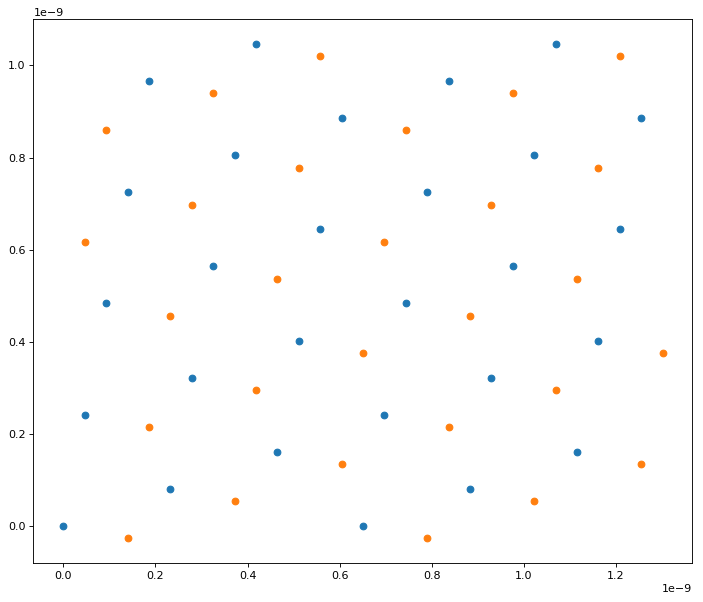

In [8]:
def get_atom_coordinates():
    pos_a = np.zeros((Nu,2))
    pos_b = np.zeros((Nu,2))
    
    count = 0
    for i in range(0, t1+n+1):
        for j in range(t2, m+1):
            
            flag1 = (float(t2*i)/float(t1) <= j)
            flag2 = (float(m*i)/float(n) >= j)
            flag3 = (float(t2*(i-n))/float(t1) > (j-m))
            flag4 = (float(m*(i-t1))/float(n) < (j-t2))
            
            if (flag1 and flag2 and flag3 and flag4):
                pos_a[count,:] = i*a1 + j*a2
                pos_b[count,:] = pos_a[count,:] + aCC_vec
                
                if(pos_a[count,0] > ch_vec[0]):
                    pos_a[count,0] -= ch_vec[0]
                if(pos_a[count,0] < 0.0):
                    pos_a[count,0] += ch_vec[0]
                if (pos_a[count,1] > ch_vec[1]):
                    pos_a[count,1] -= ch_vec[1]
                if(pos_a[count,1] < 0.0):
                    pos_a[count,1] += ch_vec[1]

                if(pos_b[count,0] > ch_vec[0]):
                    pos_b[count,0] -= ch_vec[0]
                if(pos_b[count,0] < 0.0):
                    pos_b[count,0] += ch_vec[0]
                if(pos_b[count,0] > ch_vec[1]):
                    pos_b[count,1] -= ch_vec[1]
                if(pos_b[count,1] < 0.0):
                    pos_b[count,1] += ch_vec[1]
                
                count += 1
    
    assert (count==Nu), "count: {}, Nu: {}".format(count, Nu)
    return pos_a, pos_b

pos_a, pos_b = get_atom_coordinates()

fig=plt.figure(figsize=(18, 9), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(pos_a[:,0], pos_a[:,1], linestyle='none', marker='o')
plt.plot(pos_b[:,0], pos_b[:,1], linestyle='none', marker='o')
plt.axes().set_aspect('equal')

# relative distance between a-type and b-type atoms
pos_aa = pos_a-pos_a[0,:]
pos_ab = pos_a-pos_b[0,:]
pos_ba = pos_b-pos_a[0,:]
pos_bb = pos_b-pos_b[0,:]

pos_aa[pos_aa[:,0]>(ch_vec[0]/2),0] -= ch_vec[0]
pos_ba[pos_ba[:,0]>(ch_vec[0]/2),0] -= ch_vec[0]
pos_ab[pos_ab[:,0]>(ch_vec[0]/2),0] -= ch_vec[0]
pos_bb[pos_bb[:,0]>(ch_vec[0]/2),0] -= ch_vec[0]

pos_2d = np.concatenate((pos_a, pos_b), axis=0)
pos_3d = np.stack((radius*np.cos(pos_2d[:,0]/radius), pos_2d[:,1], radius*np.sin(pos_2d[:,0])), axis=1)

# Function to get electron energy within a range of $k$ and $mu$

In [9]:
def electron_energy(n_k_min, n_k_max, n_mu_min, n_mu_max):
    n_k = n_k_max - n_k_min
    n_mu = n_mu_max - n_mu_min
    n_bands = 2
    n_atoms_in_unit_graphene_cell = n_bands
    energy = np.zeros((n_bands, n_k, n_mu))
    wavefunc = np.zeros((n_bands, n_k, n_mu, n_atoms_in_unit_graphene_cell),dtype='complex64')
    k_vector = np.zeros((n_k,1))
    for i_mu in range(n_mu_min,n_mu_max):
        for i_k in range(n_k_min, n_k_max):
            k_vector[i_k] = i_k*np.linalg.norm(dk_l)
            
            k_vec = i_mu*K1 + i_k*dk_l
            fk = np.exp(1j*np.dot(k_vec, (a1+a2)/3.))+np.exp(1j*np.dot(k_vec, (a1-2*a2)/3.))+ \
                                                            np.exp(1j*np.dot(k_vec, (a2-2*a1)/3.0))
            
            energy[0,i_k,i_mu] = np.real(-t0*np.abs(fk)) #valence band
            energy[1,i_k,i_mu] = np.real(+t0*np.abs(fk)) #conduction band
            
            wavefunc[0,i_k,i_mu,0] = 1./np.sqrt(2.)
            wavefunc[1,i_k,i_mu,0] = 1./np.sqrt(2.)
            wavefunc[0,i_k,i_mu,1] = +1./np.sqrt(2.)*np.conj(fk)/np.abs(fk)
            wavefunc[1,i_k,i_mu,1] = -1./np.sqrt(2.)*np.conj(fk)/np.abs(fk)
    return energy, wavefunc, k_vector

# Electron energy within $K_1$-extended representations

Text(0,0.5,'Energy [Jouls]')

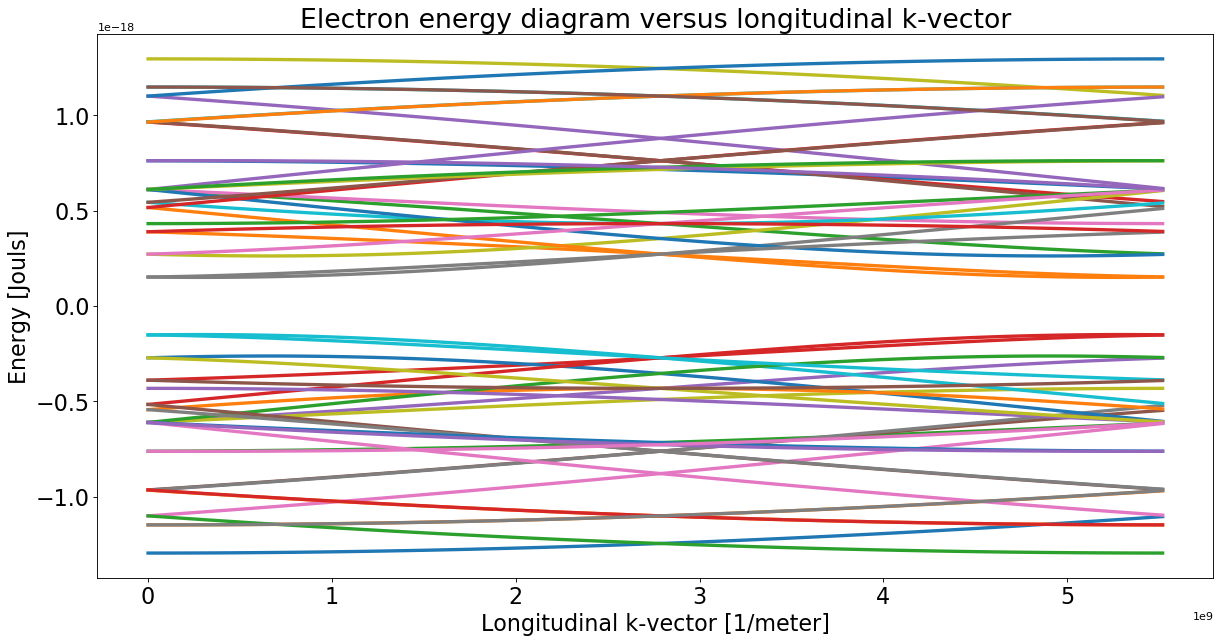

In [10]:
el_energy, el_wavefunc, k_vector = electron_energy(n_k_min=0, n_k_max=nk, n_mu_min=0, n_mu_max=Nu)

fig=plt.figure(figsize=(18, 9), dpi= 80, facecolor='w', edgecolor='k')
for dim1 in range(el_energy.shape[0]):
    for dim3 in range(el_energy.shape[2]):
        plt.plot(k_vector, el_energy[dim1,:,dim3], linestyle='-', linewidth=3)
        
plt.title('Electron energy diagram versus longitudinal k-vector', size=24)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.xlabel('Longitudinal k-vector [1/meter]', size=20)
plt.ylabel('Energy [Jouls]', size=20)

# Electron bands within $K_2$-extended representations

Text(0,0.5,'Energy [Jouls]')

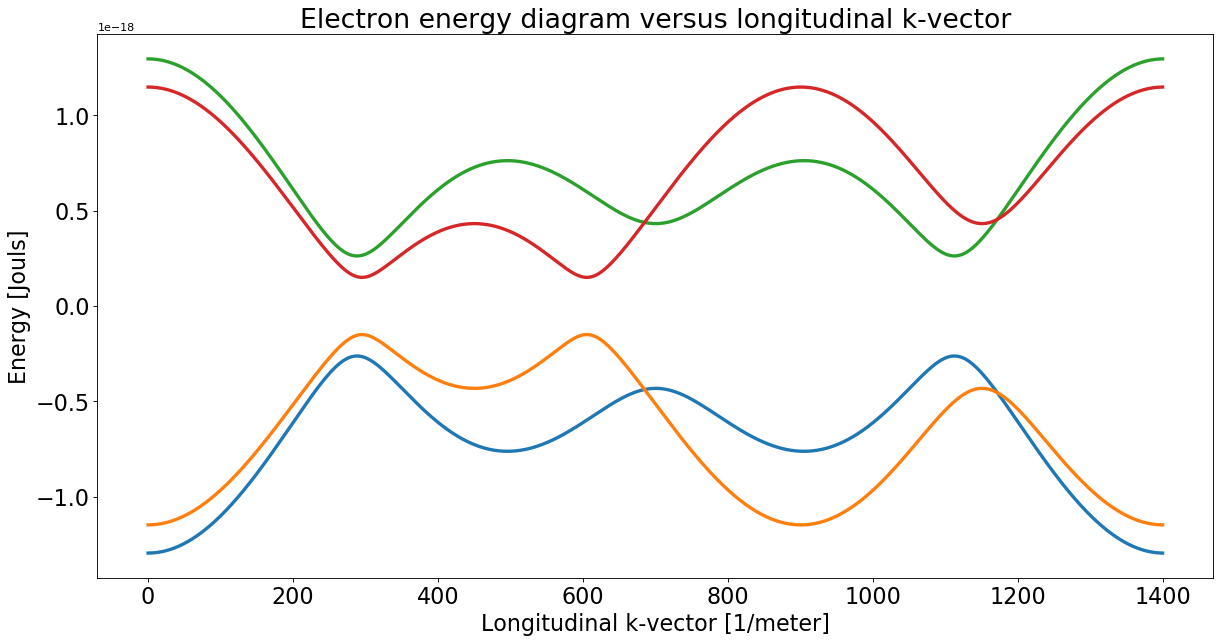

In [50]:
el_energy_K2ext, el_wavefunc_K2ext, k_vector_K2ext = \
        electron_energy(n_k_min=0, n_k_max=int(Nu/Q)*nk, n_mu_min=0, n_mu_max=Q)
# el_energy_K2ext, el_wavefunc_K2ext, k_vector_K2ext = \
#         electron_energy(n_k_min=-int(Nu/Q/2)*nk, n_k_max=int(Nu/Q/2)*nk, n_mu_min=0, n_mu_max=Q)

fig=plt.figure(figsize=(18, 9), dpi= 80, facecolor='w', edgecolor='k')
for dim1 in range(el_energy_K2ext.shape[0]):
    for dim3 in range(el_energy_K2ext.shape[2]):
#         plt.plot(k_vector_K2ext, el_energy_K2ext[dim1,:,dim3], linestyle='-', linewidth=3)
        plt.plot(np.arange(0,el_energy_K2ext.shape[1]), el_energy_K2ext[dim1,:,dim3], linestyle='-', linewidth=3)
        
plt.title('Electron energy diagram versus longitudinal k-vector', size=24)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.xlabel('Longitudinal k-vector [1/meter]', size=20)
plt.ylabel('Energy [Jouls]', size=20)
# plt.ylim([0.3e-18, 0.7e-18])

# Find and sort minimas in $K_2$-extended representation and 

In [55]:
def get_local_min_indices(two_d_array):
    assert (len(two_d_array.shape) is 2), "Input array must be two dimensional"
    local_min_index = []
    for dim1 in range(two_d_array.shape[1]):
        local_min_index.append(signal.argrelextrema(two_d_array[:,dim1], np.less, mode='wrap')[0])
    local_min_index = np.array(local_min_index)
    assert (len(local_min_index.shape) is 2), "Could not find the index of local minimas" + \
            "properly. \n local_min_index.shape: {}".format(local_min_index.shape)
    return local_min_index

# this function gets the two-dimensional local minimum indexes and turns it into list of [idx, mu]
def flatten_local_min_indices(local_min_index):
    flattened = []
    for i_mu in range(local_min_index.shape[0]):
        for idx in local_min_index[i_mu,:]:
            flattened.append([idx,i_mu])
    return flattened

# this function sort indices in order of their value in energy matrix
def bubble_sort(indices, energy):
    changed = True
    while changed:
        changed = False
        for i in range(len(indices) - 1):
            ik = indices[i][0]
            mu = indices[i][1]
            ik_plus_1 = indices[i+1][0]
            mu_plus_1 = indices[i+1][1]
            if energy[1,ik, mu] > energy[1,ik_plus_1, mu_plus_1]:
                indices[i], indices[i+1] = indices[i+1], indices[i]
                changed = True
    return indices

def find_equivalent_minimas(local_min_index, energy):
    assert (len(local_min_index)%2 is 0), "Number of local minimas is not even."
    equivalent_minimas = []
    for i in range(int(len(local_min_index)/2)):
        equivalent_minimas.append([local_min_index[2*i], local_min_index[2*i+1]])
    
    # check if the equivalent valeies are really equivalent
    for item in equivalent_minimas:
        en1 = energy[1,item[0][0], item[0][1]]
        en2 = energy[1,item[1][0], item[1][1]]
        assert (np.abs(en1-en2)/np.mean([en1, en2]) < 1.e-2), "Error in finding equivalent valeys"
    return equivalent_minimas
        
local_min_index = get_local_min_indices(el_energy_K2ext[1,:,:])
local_min_index = flatten_local_min_indices(local_min_index)
local_min_index = bubble_sort(local_min_index, el_energy_K2ext)
local_min_index = find_equivalent_minimas(local_min_index, el_energy_K2ext)
print(local_min_index)

[[295, 1], [605, 1], [288, 0], [1112, 0], [700, 0], [1150, 1]]
[[[295, 1], [605, 1]], [[288, 0], [1112, 0]], [[700, 0], [1150, 1]]]
